# Feature exploration - Age - Gender, Life Satisfaction, Political leaning

The following was part of the initial effort on better understanding the questions availabe and looking for features in use for the classifier.

#### I) Import the neccessary libraries and the dataframe

In [45]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# Suppress warning about mixed data types in columns (change this later?)
import warnings
warnings.filterwarnings('ignore')

# Import Some of the useful defined functions
import useful_fun as uf
# object with different useful regions defined
regions = uf.Regions()

In [46]:
# Extract the the zipped csv data if it already hasn't been extracted 
import os.path
import zipfile

if not os.path.isfile('./data/LiTS_III_2016.csv'):
    with zipfile.ZipFile("./data/LiTS_III_2016.zip","r") as zip_ref:
        zip_ref.extractall("./data/")
else:
    print('File already present')

File already present


### Get the data

In [47]:
# Reading the dataframe
lits_2016_full = pd.read_csv('./data/LiTS_III_2016.csv') # data in the repo folder linux
# lits_2016 = pd.read_csv('LiTS III.csv')
# Select only the columns we're interested in (can increase this as we go along)
good_cols = ['country', 'age_pr', 'gender_pr', 'weight_sample', 'weight_one', 'q401e', 'q412', 'q421', 'q223']
lits_2016_selected = lits_2016_full.loc[:, good_cols]
# Give the columns new names
good_names = ['Country', 'Age', 'Gender', 'Weight Sample', 'Weight 1', 'Life Satisfaction', 'Political System', 'Inequality', 'Monthly Income']
lits_2016_selected.columns = good_names # set the column names

In [48]:
# Dataframe with "per country" structure
original_satisfaction = pd.DataFrame()
original_satisfaction['Country'] = regions.allCountries
original_satisfaction['Transition'] = original_satisfaction['Country'].apply(uf.transition_recoder)
original_satisfaction['Region'] = original_satisfaction['Country'].apply(uf.region_recoder)
original_satisfaction['Life Satisfaction (%)'] = [48, 30, 53, 41, 40, 37, 56, 48, 71, 35, 42, 73, 24, 33, 43, 67, 43, 75, 64, 56, 24, 55, 46, 58, 45, 32, 46, 50, 69, 75, 42, 26, 93]
original_satisfaction.head()

,Country,Transition,Region,Life Satisfaction (%)
0,Albania,True,SE Europe,48
1,Armenia,True,E Europe & Caucasus,30
2,Azerbaijan,True,E Europe & Caucasus,53
3,Belarus,True,E Europe & Caucasus,41
4,Bosnia and Herz.,True,SE Europe,40


In [50]:
# Define exclusions and criteria.

# We want to exclude those rows for which life satisfaction is NaN, -97 ('don't know'), or -98 ('not applicable')
satisfaction_exclusions = [np.nan, -97, -98]

# We want to use those rows for which the answer to the life satisfaction statement was either 'agree' (4) or 'strongly agree' (5)
satisfaction_criteria = [4, 5]

In [51]:
replicated_satisfaction = pd.DataFrame()
replicated_satisfaction[['Country', 'Transition', 'Region']] = original_satisfaction[['Country', 'Transition', 'Region']]
replicated_satisfaction['Life Satisfaction (%)'] = replicated_satisfaction['Country'].apply(uf.calc_mean_percentage, args=(lits_2016_selected, ['Life Satisfaction'], satisfaction_exclusions, satisfaction_criteria)).round(1)

## Male to female ratio surveyed 
We can see that the primary respondent in the survey have been women

In [52]:
# 1 - Male; 2 - Female
fem_to_male_ratio = np.sum(lits_2016_selected['Gender']==2)/np.sum(lits_2016_selected['Gender']==1)
print('The ratio of women to men as primary repondents was: {:2.2f}  '.format(fem_to_male_ratio))

The ratio of women to men as primary repondents was: 1.28  


## Age distributions for primary repondents

In [53]:
male_respondents = lits_2016_selected[lits_2016_selected['Gender']==1]
female_respondents = lits_2016_selected[lits_2016_selected['Gender']==2]

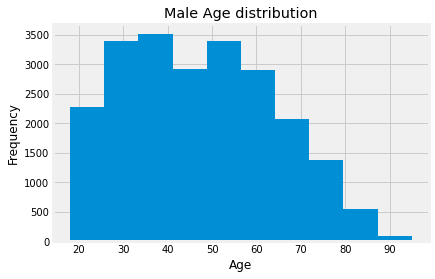

In [54]:
male_respondents['Age'].plot.hist()
plt.xlabel('Age');
plt.title('Male Age distribution');

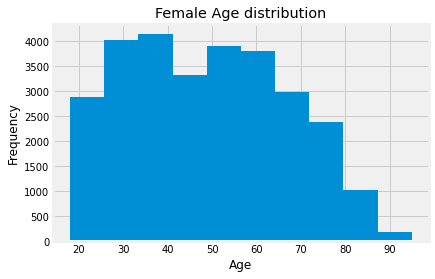

In [55]:
female_respondents['Age'].plot.hist()
plt.xlabel('Age');
plt.title('Female Age distribution');

## Life Satisfaction and Age

In [56]:
from scipy.stats import linregress

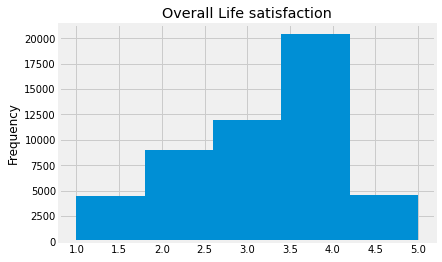

In [57]:
life_satisfaction = uf.exclude_values(lits_2016_selected,['Life Satisfaction'],satisfaction_exclusions)
life_satisfaction['Life Satisfaction'].plot.hist('Life Satisfaction',bins=5)
plt.title('Overall Life satisfaction');

In [58]:
oldest_part = life_satisfaction['Age'].max()
youngest_part = life_satisfaction['Age'].min()
print('Youngest person: {} Olderst person: {}'.format(youngest_part,oldest_part))

Youngest person: 18 Olderst person: 95


In [59]:
# Calculate the average life satisfaction per age.
range_18_to_95 = range(18,95,1)
avg_life_sat = [np.mean(life_satisfaction[life_satisfaction['Age']==age]['Life Satisfaction']) for age in range_18_to_95]

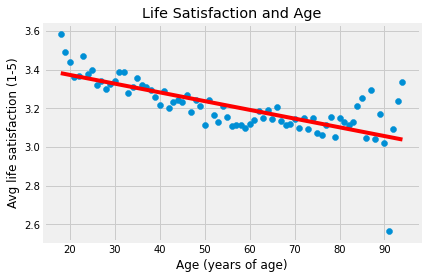

In [60]:
plt.scatter(range_18_to_95,avg_life_sat)
plt.xlabel('Age (years of age)');
plt.ylabel('Avg life satisfaction (1-5)');
plt.title('Life Satisfaction and Age');

# Fit a line 
linreg = linregress(range_18_to_95, avg_life_sat)

plt.plot(range(18,95,1), linreg.intercept+linreg.slope*range_18_to_95,c='r');

In [61]:
np.mean(uf.standard_units(avg_life_sat) * uf.standard_units(range_18_to_95))

-0.7275784509343661

In [62]:
# If you just look at the ages going from 18 to 80 dropping very old age groups, the correlation becomes even stronger
np.mean(uf.standard_units(avg_life_sat[:62]) * uf.standard_units(range(18,80,1)))

-0.9042428195914931

There seems to be a relatively strong correlation to degrease in life satisfation over age and an uptic at the latter stages in life. This seems to also have previous results in literature.

(Gerstorf, D., Ram, N., Röcke, C., Lindenberger, U., & Smith, J. (2008). Decline in life satisfaction in old age: longitudinal evidence for links to distance-to-death. Psychology and aging, 23(1), 154.)

## Political Preference and Age
### Market v Planned economy
q411 (p23 - questionaire)
* 1 - **Capitalist** - A market economy is preferable to any other form of economic system.
* 2 - **Social** - Under some circumstances, a planned economy may be preferable to a market economy.
* 3 - **Indiferent** - For people like me, it does not matter whether the economic system is organised as a market economy or as a planned economy.
* -97 - Don't know.  

### Democratic v Authoritarian system
q412 (p23 - questionaire)
* 1 - **Democratic** - Democracy is preferable to any other form of political system.
* 2 - **Authoritarian** - Under some circumstances, an authoritarian government may be preferable to a democratic one.
* 3 - **Indiferent** - For people like me, it does not matter whether a government is democratic or authoritarian.
* -97 - Don't know.  


In [74]:
def exclude_values(df, measure, exclusions):
    # Clean the dataframe by removing rows with the excluded values in the measure column.
    df_overall = df.copy()
    for i in np.arange(len(exclusions)):
        indices = df[df[measure] == exclusions[i]].index
        df_overall = df_overall.drop(indices)
    return df_overall


def calc_mean_percentage(val, df, measure, exclusions, criteria):
    # Clean the dataframe by removing rows with the excluded values in the measure column.
    df_overall = exclude_values(df, measure, exclusions)
    # Create a new dataframe that contains only those rows that passed the criteria on the measure column.
    df_select = uf.include_values(df, measure, criteria)
    
    # If a string was passed to countries, convert it into an array.
    if type(val) == np.str:
        val = [val]
    
    # Calculate the mean percentage(s).
    percentages = np.zeros(len(val))
    for k in np.arange(len(val)):
        percentages[k] = np.sum(df_select[df_select['Age'] == val[k]]['Weight 1']) / np.sum(df_overall[df_overall['Age'] == val[k]]['Weight 1']) * 100

    print('Total mean percentage: {:2.2f}%'.format(np.mean(percentages)))
    
    return percentages

In [75]:
# Dataframe structure to be used
ageDataframe = pd.DataFrame()
ageRange = range(18,95,1)
ageDataframe['Age'] = ageRange

## Q411

### General criteria

Total mean percentage: 19.97%


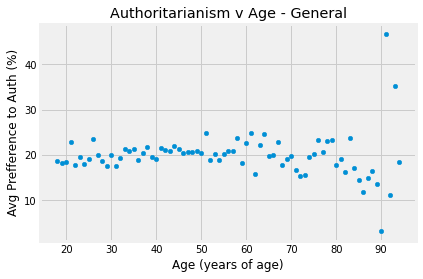

In [78]:
# Define exclusions and criteria. - Prefference to authoritarianins
politics_exclusions = [np.nan, -97]
politics_criteria = [2]

age_v_politics_general = pd.DataFrame()
age_v_politics_general = ageDataframe
# Calculate the percentage per age
age_v_politics_general['Authoritarianism (%)'] = calc_mean_percentage(age_v_politics_general['Age'],lits_2016_selected,'Political System', politics_exclusions, politics_criteria)

# Plot
age_v_politics_general.plot.scatter('Age','Authoritarianism (%)')
plt.xlabel('Age (years of age)');
plt.ylabel('Avg Prefference to Auth (%)');
plt.title('Authoritarianism v Age - General');

### Guardian Criteria

Total mean percentage: 51.03%


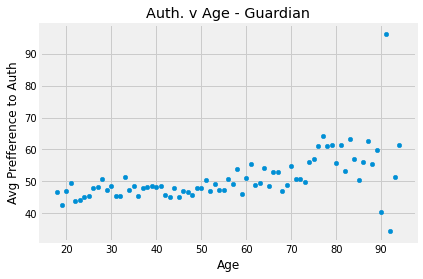

In [79]:
# Define exclusions and criteria.
guardian_exclusions = [np.nan]
guardian_criteria = [-97, 2, 3]

age_v_politics_guardian = pd.DataFrame()
age_v_politics_guardian = ageDataframe
# Calculate the percentage per age
age_v_politics_guardian['Authoritarianism (%)'] = calc_mean_percentage(age_v_politics_guardian['Age'],lits_2016_selected,'Political System', guardian_exclusions, guardian_criteria)

# Plot
age_v_politics_guardian.plot.scatter('Age','Authoritarianism (%)')
plt.xlabel('Age');
plt.ylabel('Avg Prefference to Auth');
plt.title('Auth. v Age - Guardian');

## What about ex soviet states?

In [80]:
# What proportion of the countries that were surveyed are ex soviet?
ratio_soviet_states = len(regions.ussr)/len(regions.allCountries)
print('The ratio of all states surveyed to ussr states: {:2.2}'.format(ratio_soviet_states))

# Select only the soviet states
# lits_ex_soviet = lits_2016_selected[[regions.ussr.__contains__(row) for row in lits_2016_selected['Country']]]
lits_ex_soviet = uf.include_values(lits_2016_selected,'Country',regions.ussr)

The ratio of all states surveyed to ussr states: 0.45


### General Criteria - ussr

Total mean percentage: 19.89%


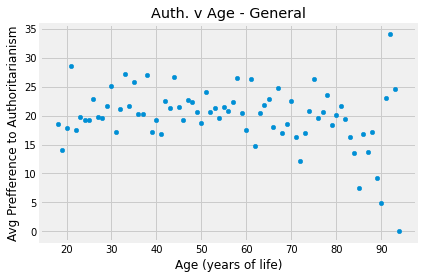

In [81]:
# Define exclusions and criteria. - Prefference to authoritarianins
politics_exclusions = [np.nan, -97]
politics_criteria = [2]

age_v_politics_ussr = pd.DataFrame()
age_v_politics_ussr = ageDataframe
# Calculate the percentage per age
age_v_politics_ussr['Authoritarianism (%)'] = calc_mean_percentage(age_v_politics_ussr['Age'],lits_ex_soviet,'Political System', politics_exclusions, politics_criteria)

# Plot
age_v_politics_ussr.plot.scatter('Age','Authoritarianism (%)')
plt.xlabel('Age (years of life)');
plt.ylabel('Avg Prefference to Authoritarianism');
plt.title('Auth. v Age - General');

### Guardian Criteria - ussr

Total mean percentage: 56.76%


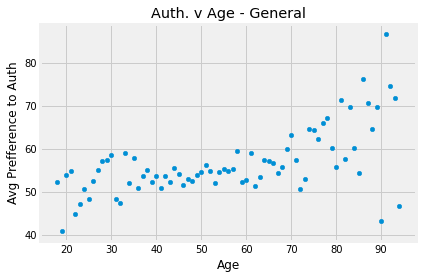

In [82]:
# Define exclusions and criteria. - Prefference to authoritarianins
guardian_exclusions = [np.nan]
guardian_criteria = [-97, 2, 3]

age_v_politics_ussr_guardian = pd.DataFrame()
age_v_politics_ussr_guardian = ageDataframe
# Calculate the percentage per age
age_v_politics_ussr['Authoritarianism (%)'] = calc_mean_percentage(age_v_politics_ussr['Age'],lits_ex_soviet,'Political System', guardian_exclusions, guardian_criteria)

# Plot
age_v_politics_ussr_guardian.plot.scatter('Age','Authoritarianism (%)')
plt.xlabel('Age');
plt.ylabel('Avg Prefference to Auth');
plt.title('Auth. v Age - General');

### Conclusion

* There seemes to be an intersting connection between the life satisfaction and age.
* There seemes to be a significant enough variation between age and political leaning, so we'll try to use age as a feature in classification.